In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline

In [ ]:
# This exercise is based on data from the US Census Bureau: American Community Survey 5-year data (2009-2015)
# The point of the exercise is to display a few statistics on income and inequality

In [ ]:
# background information: https://www.census.gov/data/developers/data-sets/acs-5year.html
# list of variables also here: https://api.census.gov/data/2015/acs5/profile/variables.html
# sample queries: http://api.census.gov/data/2015/acs5/profile/examples.html

In [3]:
def getDataFromCensus(query_str):
    tmp_df = pd.read_json(query_str)
    tmp_df2 = tmp_df.iloc[1:tmp_df.shape[0],:].copy()
    tmp_df2.columns = tmp_df.iloc[0,:]
    return tmp_df2

In [4]:
income_brackets = {'DP03_0051E':'All', 'DP03_0052E':'0-10,000', 'DP03_0053E':'10,000-14,999','DP03_0054E':'15,000-24,999',
                   'DP03_0055E':'25,000-34,999','DP03_0056E':'35,000-49,999','DP03_0057E':'50,000-74,999',
                   'DP03_0058E':'75,000-99,999','DP03_0059E':'100,000-149,999','DP03_0060E':'150,000-199,999','DP03_0061E':'200,000-'}

# Measuring household income inequality

In [5]:
# get median earnings by state
median_earnings_str = 'DP03_0062E'
median_earnings_by_state = getDataFromCensus('http://api.census.gov/data/2015/acs5/profile?get='+median_earnings_str+',NAME&for=state:*')

In [6]:
median_earnings_by_state.head()

,DP03_0062E,NAME,state
1,43623,Alabama,01
2,72515,Alaska,02
3,50255,Arizona,04
4,41371,Arkansas,05
5,61818,California,06


In [7]:
# get mean earnings by state
mean_earnings_str = 'DP03_0063E'
mean_earnings_by_state = getDataFromCensus('http://api.census.gov/data/2015/acs5/profile?get='+mean_earnings_str+',NAME&for=state:*')

In [8]:
tmp_df = median_earnings_by_state.copy()
tmp_df.columns = median_earnings_by_state.iloc[0,:]
tmp_df2 = tmp_df.iloc[1:tmp_df.shape[0],:]
tmp_df_median = tmp_df2
tmp_df_median.columns = ['Median','NAME','state']
tmp_df_median.index = list(tmp_df_median.NAME)
tmp_df_median.head()

,Median,NAME,state
Alaska,72515,Alaska,02
Arizona,50255,Arizona,04
Arkansas,41371,Arkansas,05
California,61818,California,06
Colorado,60629,Colorado,08


In [9]:
tmp_df_mean = mean_earnings_by_state.copy().iloc[1:mean_earnings_by_state.shape[0],:]
tmp_df_mean.columns = mean_earnings_by_state.iloc[0,:]
tmp_df_mean.columns = ['Mean','NAME','state']
tmp_df_mean.index = list(tmp_df_mean.NAME)
tmp_df_mean.head()

,Mean,NAME,state
Alaska,89746,Alaska,02
Arizona,68297,Arizona,04
Arkansas,57304,Arkansas,05
California,87877,California,06
Colorado,81635,Colorado,08


In [11]:
states = list(tmp_df_mean.NAME)

# Median household income distribution

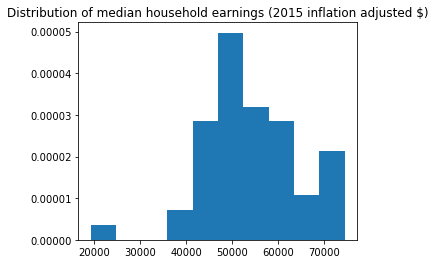

In [12]:
plt.figure(figsize=(5,4))
plt.hist(tmp_df_median.loc[states,'Median'].values.astype(float),10, normed=True,cumulative=False)
plt.title('Distribution of median household earnings (2015 inflation adjusted $)')
plt.show()

# Inequality: mean household earnings relative to median household earnings

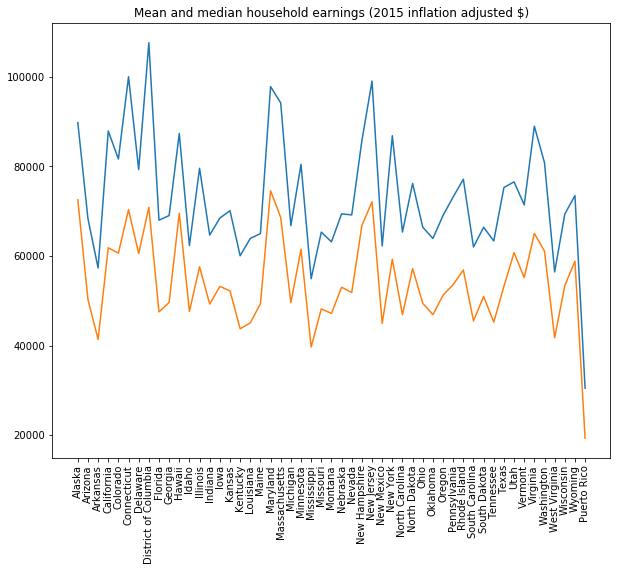

In [13]:
plt.figure(figsize=(10,8))
plt.plot(tmp_df_mean.loc[states,'Mean'].values.astype(float))
plt.plot(tmp_df_median.loc[states,'Median'].values.astype(float))
plt.xticks(range(tmp_df_mean.iloc[:,0].shape[0]),states, rotation = 90)
plt.title('Mean and median household earnings (2015 inflation adjusted $)')
plt.show()

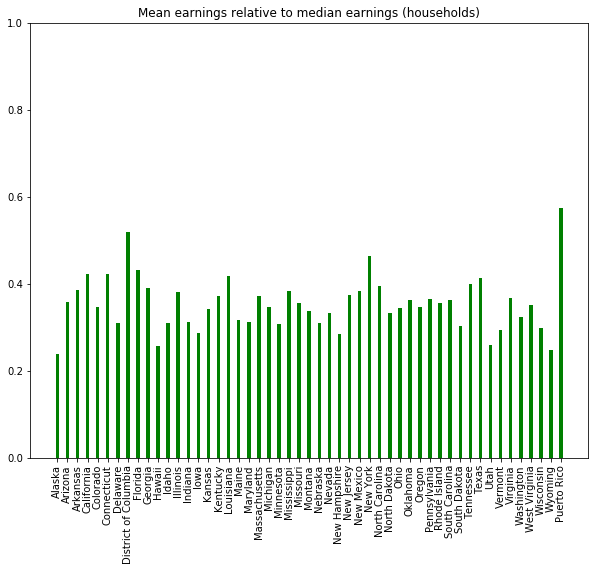

In [15]:
plt.figure(figsize=(10,8))
y1 = tmp_df_mean.loc[states,'Mean'].values.astype(float)
y2 = tmp_df_median.loc[states,'Median'].values.astype(float)
inds = np.arange(y1.shape[0])
width = 0.35
plt.bar(inds, y1/y2-1, width,color='g')
plt.title('Mean earnings relative to median earnings (households)')
plt.xticks(inds,states, rotation = 90)
plt.ylim(0,1)
plt.show()

# Relationship between # of rich households and # of poor households is negative -> inequality across states?

In [16]:
bracket_list = list(income_brackets.keys())

In [17]:
all_df = getDataFromCensus('http://api.census.gov/data/2015/acs5/profile?get='+bracket_list[0]+',NAME&for=state:*')
del all_df['state']
for ticker in bracket_list[1:len(bracket_list)+1]:
    tmp_df = getDataFromCensus('http://api.census.gov/data/2015/acs5/profile?get='+ticker+',NAME&for=state:*')
    del tmp_df['state']
    all_df = pd.merge(all_df, tmp_df, how='inner', on='NAME')

In [18]:
red_brackets = all_df[['DP03_0052E','DP03_0053E','DP03_0054E']].values.astype(int).sum(axis=1)

In [19]:
pct_poor = 100*red_brackets.astype(float)/all_df['DP03_0051E'].values.astype(float)

In [20]:
pct_rich = 100*all_df['DP03_0061E'].values.astype(float)/all_df['DP03_0051E'].values.astype(float)

Inequality can be looked at from two perspectives: intra-state and inter-state. One might think that states with a higher percentage of richer households also have a higher percent of poor households (or "rich take from poor, so fat tails on both sides"). The scatter plot rejects this hypothesis and seems to imply that there is an inter-state aspect to inequality: some states have more poor than others. Caveats: size of household and state living standard are not taken into account.  

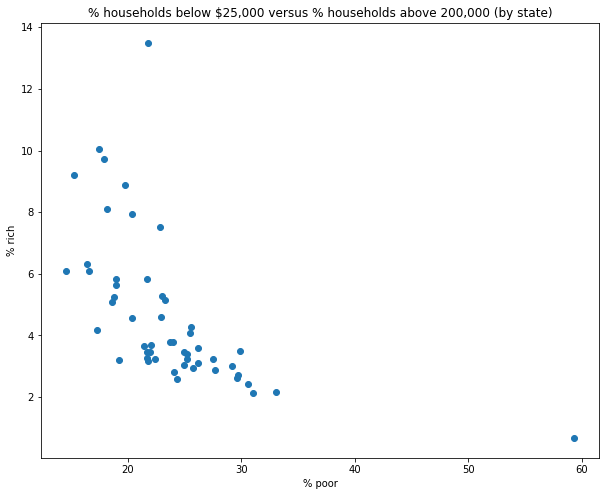

In [21]:
plt.figure(figsize=(10,8))
plt.scatter(pct_poor, pct_rich)
plt.title('% households below $25,000 versus % households above 200,000 (by state)')
plt.xlabel('% poor')
plt.ylabel('% rich')
plt.show()

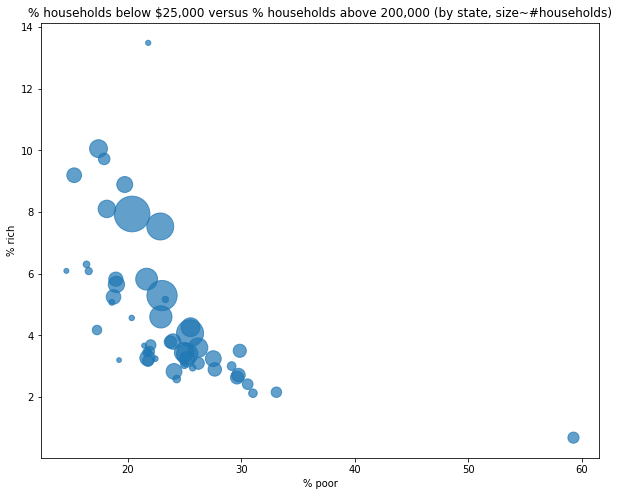

In [22]:
plt.figure(figsize=(10,8))
plt.scatter(pct_poor, pct_rich, s=all_df['DP03_0051E'].astype(float).divide(1e4), alpha=0.7)
plt.title('% households below $25,000 versus % households above 200,000 (by state, size~#households)')
plt.xlabel('% poor')
plt.ylabel('% rich')
plt.show()